In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc

import scipy.interpolate

In [21]:
Omega_M = 0.3
Omega_R = 7e-5
Omega_lambda = 1 - Omega_M - Omega_R
Tv_k = 1.947
# in MeV
kb = 8.617e-11 # MeV/K
T0 = Tv_k * kb
H0 = 67 / (3*1e5) # i 1/Mpc
mv_test = 5 # eV

kvec = np.logspace(-6,1,7)
kvec = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1]
cosmo_dict ={'H0':70,  'Omega_cdm':Omega_M, 'k_output_values':str(kvec).strip('[]'), "N_ncdm":1,
             "m_ncdm":mv_test # massen er givet i eV s' jeg min egen test m_v skal være en faktor  1e-6 mindre
           ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
            "ncdm_fluid_approximation":3
            }

cosmo = Class()
cosmo.set(cosmo_dict)
cosmo.compute()
bg = cosmo.get_background()
pts = cosmo.get_perturbations()['scalar']
#print(bg.keys())
z = bg["z"]
a = 1/(z+1)
aend = a[-1]
a0 = a[0]
mv = mv_test * 1e-6
# cs front faktoren
factor = 2.68

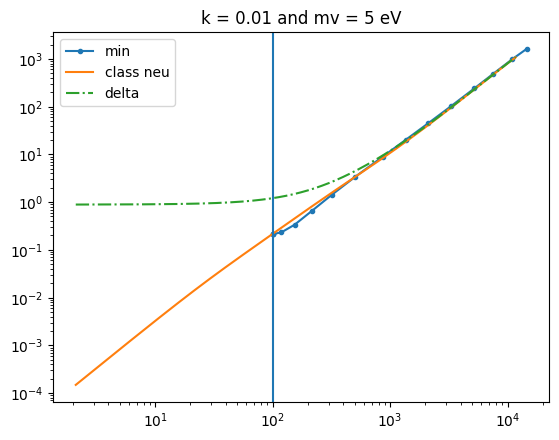

In [41]:
x = 50000
k_ind = -3
k = kvec[k_ind]
T_ini = 100 #x / k
# cs front faktoren
factor = 1e-1#2.68


# udregner Hubbleparameteren

def H(a):
    return H0 * np.sqrt(Omega_lambda + Omega_M /( a **3) + Omega_R /( a**4)) 

# udregnger tau 

def tau_cal(a,y):
    # Vores "tids"-værdi i denne differentialligning er a
    tau = y[0]
    d_tau = 1 / (a ** 2 * H(a))
    return np.array(d_tau)

# temperatur

def Tv(a):
    return T0 / a # in MeV

# lydhastighed

def cs(a,mv,factor):
    return factor * Tv(a) / mv

# udregn a
def a_solve(tau,y):
    a = y[0]
    a_dt = a * a * H(a)
    return [a_dt]

tau_init =   (1/H0) * (Omega_R ** (-0.5)) * a0


sol_tau = sc.solve_ivp(tau_cal,t_span=[a0,aend],y0=[tau_init])
tau = sol_tau.y[0]

sol_a = sc.solve_ivp(a_solve,t_span=[tau[0],tau[-1]],y0=[a0])
a_tau = sol_a.t
a = sol_a.y[0]

a_interp = scipy.interpolate.interp1d(a_tau,a)

# sammenlignings data fra Class

delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
#delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
#theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)

delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]

a_class = pts[k_ind]["a"]

#delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
#theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)

def delta_neutrino_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["delta_ncdm[0]"])(T_ini)

def theta_neutrino_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["theta_ncdm[0]"])(T_ini)

def delta_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["delta_cdm"])(T_ini)

def theta_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["theta_cdm"])(T_ini)

t_span = [T_ini,tau[-1]]


def cdm_func1(t,y):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
    d_theta   =  - nabla2phi-  H(a) * theta * a
    return [d_delta,d_theta]

y01 = [delta_init(k_ind),theta_init(k_ind)]

sol_cdm1 = sc.solve_ivp(cdm_func1, t_span = t_span, y0 = y01)

t_cdm1 = sol_cdm1.t
delta_cdm1 = sol_cdm1.y[0]


delta_cdm_interp = scipy.interpolate.interp1d(t_cdm1,delta_cdm1)

def cs(a,mv,factor):
    return factor * Tv(a) / mv

def neu_func1(t,y,k,mv,factor):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    delta_cdm = delta_cdm_interp(t)
    d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta
    return [d_delta,d_theta]


y01_neutrino = [delta_neutrino_init(k_ind),theta_neutrino_init(k_ind)]
factor = 2.68
sol_neu1 = sc.solve_ivp(neu_func1, t_span = t_span, y0 = y01_neutrino,args=(k,mv,factor))

t_nue1 = sol_neu1.t
delta_neu1 = sol_neu1.y[0]
plt.loglog(t_nue1,-delta_neu1,".-",label="min")
plt.loglog(tau_class,-delta_neutrino_class,label="class neu")
plt.title("k = %s and mv = %s eV" %(kvec[k_ind],mv_test))
plt.loglog(tau_class,-delta_class,"-.",label="delta")
plt.legend()
plt.axvline(T_ini)

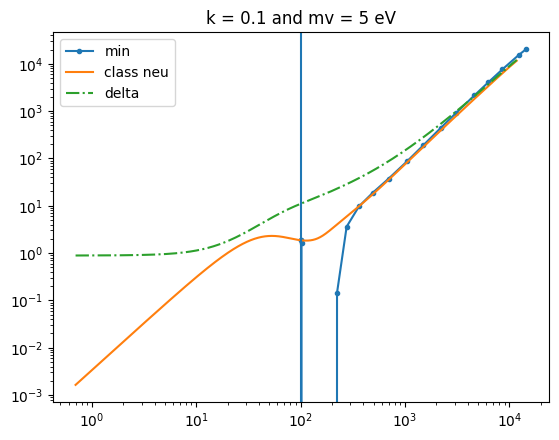

In [42]:
x = 50000
k_ind = -2
k = kvec[k_ind]
T_ini = 100 #x / k
# cs front faktoren
factor = 1e-1#2.68


delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
#delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
#theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)

delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]

a_class = pts[k_ind]["a"]

#delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
#theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)

def delta_neutrino_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["delta_ncdm[0]"])(T_ini)

def theta_neutrino_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["theta_ncdm[0]"])(T_ini)

def delta_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["delta_cdm"])(T_ini)

def theta_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["theta_cdm"])(T_ini)

t_span = [T_ini,tau[-1]]


def cdm_func1(t,y):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
    d_theta   =  - nabla2phi-  H(a) * theta * a
    return [d_delta,d_theta]

y01 = [delta_init(k_ind),theta_init(k_ind)]

sol_cdm1 = sc.solve_ivp(cdm_func1, t_span = t_span, y0 = y01)

t_cdm1 = sol_cdm1.t
delta_cdm1 = sol_cdm1.y[0]


delta_cdm_interp = scipy.interpolate.interp1d(t_cdm1,delta_cdm1)

def cs(a,mv,factor):
    return factor * Tv(a) / mv

def neu_func1(t,y,k,mv,factor):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    delta_cdm = delta_cdm_interp(t)
    d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta
    return [d_delta,d_theta]


y01_neutrino = [delta_neutrino_init(k_ind),theta_neutrino_init(k_ind)]
factor = 2.68
sol_neu1 = sc.solve_ivp(neu_func1, t_span = t_span, y0 = y01_neutrino,args=(k,mv,factor))

t_nue1 = sol_neu1.t
delta_neu1 = sol_neu1.y[0]
plt.loglog(t_nue1,-delta_neu1,".-",label="min")
plt.loglog(tau_class,-delta_neutrino_class,label="class neu")
plt.title("k = %s and mv = %s eV" %(kvec[k_ind],mv_test))
plt.loglog(tau_class,-delta_class,"-.",label="delta")
plt.legend()
plt.axvline(T_ini)

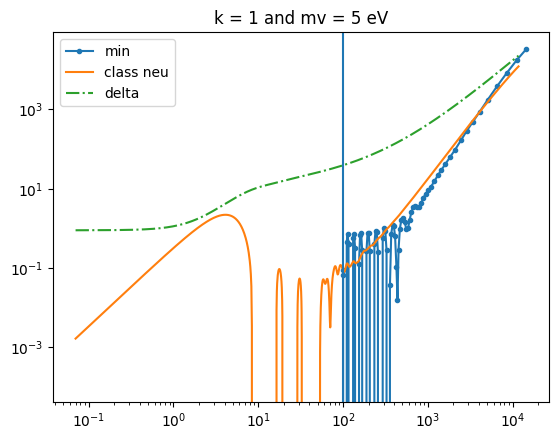

In [43]:
x = 50000
k_ind = -1
k = kvec[k_ind]
T_ini = 100 #x / k
# cs front faktoren
factor = 1e-1#2.68


delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
#delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
#theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)

delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]

a_class = pts[k_ind]["a"]

#delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
#theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)

def delta_neutrino_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["delta_ncdm[0]"])(T_ini)

def theta_neutrino_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["theta_ncdm[0]"])(T_ini)

def delta_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["delta_cdm"])(T_ini)

def theta_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["theta_cdm"])(T_ini)

t_span = [T_ini,tau[-1]]


def cdm_func1(t,y):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
    d_theta   =  - nabla2phi-  H(a) * theta * a
    return [d_delta,d_theta]

y01 = [delta_init(k_ind),theta_init(k_ind)]

sol_cdm1 = sc.solve_ivp(cdm_func1, t_span = t_span, y0 = y01)

t_cdm1 = sol_cdm1.t
delta_cdm1 = sol_cdm1.y[0]


delta_cdm_interp = scipy.interpolate.interp1d(t_cdm1,delta_cdm1)

def cs(a,mv,factor):
    return factor * Tv(a) / mv

def neu_func1(t,y,k,mv,factor):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    delta_cdm = delta_cdm_interp(t)
    d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta
    return [d_delta,d_theta]


y01_neutrino = [delta_neutrino_init(k_ind),theta_neutrino_init(k_ind)]
factor = 2.68
sol_neu1 = sc.solve_ivp(neu_func1, t_span = t_span, y0 = y01_neutrino,args=(k,mv,factor))

t_nue1 = sol_neu1.t
delta_neu1 = sol_neu1.y[0]
plt.loglog(t_nue1,-delta_neu1,".-",label="min")
plt.loglog(tau_class,-delta_neutrino_class,label="class neu")
plt.title("k = %s and mv = %s eV" %(kvec[k_ind],mv_test))
plt.loglog(tau_class,-delta_class,"-.",label="delta")
plt.legend()
plt.axvline(T_ini)

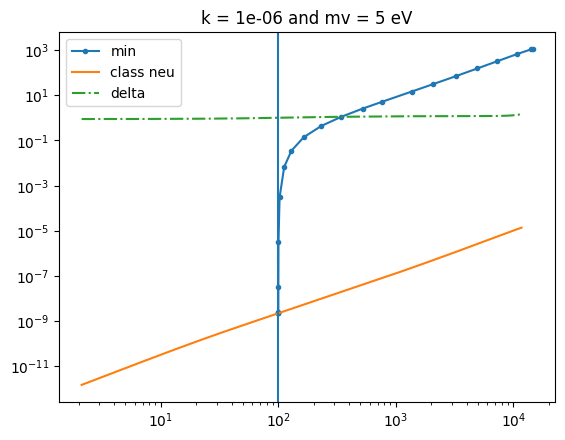

In [44]:
x = 50000
k_ind = 0
k = kvec[k_ind]
T_ini = 100 #x / k
# cs front faktoren
factor = 1e-1#2.68


delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
#delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
#theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)

delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]

a_class = pts[k_ind]["a"]

#delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
#theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)

def delta_neutrino_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["delta_ncdm[0]"])(T_ini)

def theta_neutrino_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["theta_ncdm[0]"])(T_ini)

def delta_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["delta_cdm"])(T_ini)

def theta_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["theta_cdm"])(T_ini)

t_span = [T_ini,tau[-1]]


def cdm_func1(t,y):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
    d_theta   =  - nabla2phi-  H(a) * theta * a
    return [d_delta,d_theta]

y01 = [delta_init(k_ind),theta_init(k_ind)]

sol_cdm1 = sc.solve_ivp(cdm_func1, t_span = t_span, y0 = y01)

t_cdm1 = sol_cdm1.t
delta_cdm1 = sol_cdm1.y[0]


delta_cdm_interp = scipy.interpolate.interp1d(t_cdm1,delta_cdm1)

def cs(a,mv,factor):
    return factor * Tv(a) / mv

def neu_func1(t,y,k,mv,factor):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    delta_cdm = delta_cdm_interp(t)
    d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta
    return [d_delta,d_theta]


y01_neutrino = [delta_neutrino_init(k_ind),theta_neutrino_init(k_ind)]
factor = 2.68
sol_neu1 = sc.solve_ivp(neu_func1, t_span = t_span, y0 = y01_neutrino,args=(k,mv,factor))

t_nue1 = sol_neu1.t
delta_neu1 = sol_neu1.y[0]
plt.loglog(t_nue1,-delta_neu1,".-",label="min")
plt.loglog(tau_class,-delta_neutrino_class,label="class neu")
plt.title("k = %s and mv = %s eV" %(kvec[k_ind],mv_test))
plt.loglog(tau_class,-delta_class,"-.",label="delta")
plt.legend()
plt.axvline(T_ini)

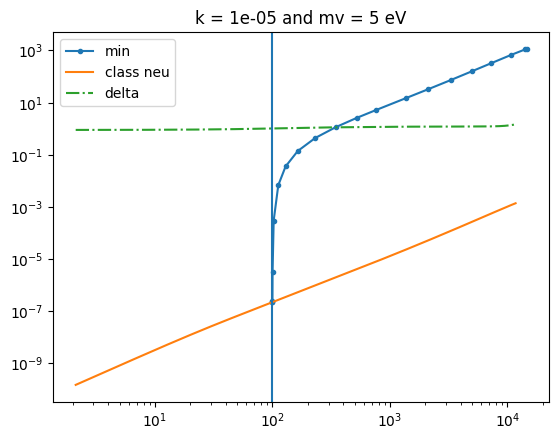

In [49]:
x = 50000
k_ind = 1
k = kvec[k_ind]
T_ini = 100 #x / k
# cs front faktoren
#factor = 2.68


delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
#delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
#theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)

delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]

a_class = pts[k_ind]["a"]

#delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
#theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)

def delta_neutrino_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["delta_ncdm[0]"])(T_ini)

def theta_neutrino_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["theta_ncdm[0]"])(T_ini)

def delta_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["delta_cdm"])(T_ini)

def theta_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["theta_cdm"])(T_ini)

t_span = [T_ini,tau[-1]]


def cdm_func1(t,y):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
    d_theta   =  - nabla2phi-  H(a) * theta * a
    return [d_delta,d_theta]

y01 = [delta_init(k_ind),theta_init(k_ind)]

sol_cdm1 = sc.solve_ivp(cdm_func1, t_span = t_span, y0 = y01)

t_cdm1 = sol_cdm1.t
delta_cdm1 = sol_cdm1.y[0]


delta_cdm_interp = scipy.interpolate.interp1d(t_cdm1,delta_cdm1)

def cs(a,mv,factor):
    return factor * Tv(a) / mv

def neu_func1(t,y,k,mv,factor):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    delta_cdm = delta_cdm_interp(t)
    d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta
    return [d_delta,d_theta]


y01_neutrino = [delta_neutrino_init(k_ind),theta_neutrino_init(k_ind)]
factor = 2.68
sol_neu1 = sc.solve_ivp(neu_func1, t_span = t_span, y0 = y01_neutrino,args=(k,mv,factor))

t_nue1 = sol_neu1.t
delta_neu1 = sol_neu1.y[0]
plt.loglog(t_nue1,-delta_neu1,".-",label="min")
plt.loglog(tau_class,-delta_neutrino_class,label="class neu")
plt.title("k = %s and mv = %s eV" %(kvec[k_ind],mv_test))
plt.loglog(tau_class,-delta_class,"-.",label="delta")
plt.legend()
plt.axvline(T_ini)

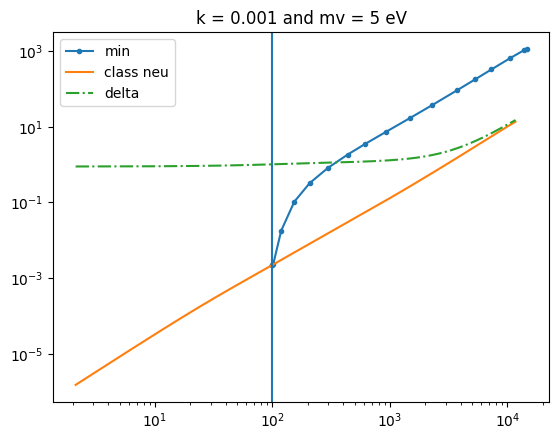

In [50]:
x = 50000
k_ind = 3
k = kvec[k_ind]
T_ini = 100 #x / k
# cs front faktoren
factor = 1e-1#2.68


delta_class = pts[k_ind]["delta_cdm"]
theta_class = pts[k_ind]["theta_cdm"]
tau_class = pts[k_ind]["tau [Mpc]"]
#delta_init = scipy.interpolate.interp1d(tau_class,delta_class)(T_ini)
#theta_init = scipy.interpolate.interp1d(tau_class,theta_class)(T_ini)

delta_neutrino_class = pts[k_ind]["delta_ncdm[0]"]
theta_neutrino_class = pts[k_ind]["theta_ncdm[0]"]

a_class = pts[k_ind]["a"]

#delta_neutrino_init = scipy.interpolate.interp1d(tau_class,delta_neutrino_class)(T_ini)
#theta_neutrino_init = scipy.interpolate.interp1d(tau_class,theta_neutrino_class)(T_ini)

def delta_neutrino_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["delta_ncdm[0]"])(T_ini)

def theta_neutrino_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["theta_ncdm[0]"])(T_ini)

def delta_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["delta_cdm"])(T_ini)

def theta_init(k_ind):
    return scipy.interpolate.interp1d(pts[k_ind]["tau [Mpc]"],pts[k_ind]["theta_cdm"])(T_ini)

t_span = [T_ini,tau[-1]]


def cdm_func1(t,y):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    nabla2phi = (3/2) * H0*H0 * Omega_M * delta / a
    d_theta   =  - nabla2phi-  H(a) * theta * a
    return [d_delta,d_theta]

y01 = [delta_init(k_ind),theta_init(k_ind)]

sol_cdm1 = sc.solve_ivp(cdm_func1, t_span = t_span, y0 = y01)

t_cdm1 = sol_cdm1.t
delta_cdm1 = sol_cdm1.y[0]


delta_cdm_interp = scipy.interpolate.interp1d(t_cdm1,delta_cdm1)

def cs(a,mv,factor):
    return factor * Tv(a) / mv

def neu_func1(t,y,k,mv,factor):
    delta = y[0]
    theta = y[1]    
    a = a_interp(t)
    d_delta   = - theta
    delta_cdm = delta_cdm_interp(t)
    d_theta   =  -  H(a) * a * theta - (3/2) * H0*H0 * Omega_M * delta_cdm / a  + k**2 * cs(a,mv,factor)**2 * delta
    return [d_delta,d_theta]


y01_neutrino = [delta_neutrino_init(k_ind),theta_neutrino_init(k_ind)]
factor = 2.68
sol_neu1 = sc.solve_ivp(neu_func1, t_span = t_span, y0 = y01_neutrino,args=(k,mv,factor))

t_nue1 = sol_neu1.t
delta_neu1 = sol_neu1.y[0]
plt.loglog(t_nue1,-delta_neu1,".-",label="min")
plt.loglog(tau_class,-delta_neutrino_class,label="class neu")
plt.title("k = %s and mv = %s eV" %(kvec[k_ind],mv_test))
plt.loglog(tau_class,-delta_class,"-.",label="delta")
plt.legend()
plt.axvline(T_ini)